## Data Augmentation

In [1]:
# Import Required Libraries

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import face_recognition
from tqdm import tqdm

In [3]:
# Mathematical Function to Return Perpendicular Distance of a Point from a Line

def get_distance_from_point_to_line(point, line_point1, line_point2):

        (p,q) = point
        (x1,y1) = line_point1
        (x2,y2) = line_point2

        A = (y2-y1)
        B = (x1-x2)
        
        distance = np.abs( A*p + B*q  - A*x1 - B*y1 ) / np.sqrt( A**2 + B**2 )

        return int(distance)

In [4]:
# Mathematical Function to Return Rotated Co-ordinates of a Point around a Reference Point (Origin)

def get_point_rotation(point,origin,angle):

        (p,q) = point
        (x,y) = origin

        rotated_p = x + np.cos(angle)*(p-x) - np.sin(angle)*(q-y)
        rotated_q = y + np.sin(angle)*(p-x) + np.cos(angle)*(q-y)

        return [int(rotated_p),int(rotated_q)]

In [5]:
# Function to Wear Mask to the Human Faces found in a given Input Image 

def Mask_Faces (image_path,mask_image_path):

  masked_faces_image = Image.open(image_path)

  image = face_recognition.load_image_file(image_path)
  mask_img = Image.open(mask_image_path)

  # Get Face Landmark Co-ordinates
  face_landmarks = face_recognition.face_landmarks(image)

  # Return if no Faces found or Required Landmarks not found
  if len(face_landmarks)==0:
    # print("No Faces found in "+image_path.split('/')[-1]+" !")
    return None

  for face in face_landmarks:

    if 'nose_bridge' not in face or 'chin' not in face :
      continue

    # Nose Point (Top of Mask)
    nose_bridge = face['nose_bridge']
    nose_point = ((np.array(nose_bridge[0])+np.array(nose_bridge[1]))/2).astype(np.uint64)

    chin = face['chin']
    chin_len = len(chin)

    # Chin Points (Bottom, Left and Right of Mask)
    chin_bottom_point = np.array(chin[chin_len // 2])       
    chin_left_point = np.array(chin[chin_len // 8])        
    chin_right_point = np.array(chin[chin_len * 7 // 8])

    # Dimensions for the Mask
    width = mask_img.width
    height = mask_img.height        
    width_ratio = 1.15       
    new_mask_height = int(np.linalg.norm(nose_point - chin_bottom_point))

    # Prepare Left Half of the Mask with appropriate Size
    mask_left_img = mask_img.crop((0, 0, width // 2, height))        
    mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)        
    mask_left_width = int(mask_left_width * width_ratio)        
    mask_left_img = mask_left_img.resize((mask_left_width, new_mask_height))
        
    # Prepare Right Half of the Mask with appropriate Size
    mask_right_img = mask_img.crop((width // 2, 0, width, height))        
    mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)        
    mask_right_width = int(mask_right_width * width_ratio)        
    mask_right_img = mask_right_img.resize((mask_right_width, new_mask_height))

    # Join the 2 Halves to Produce the New Mask Image with the Correct Size
    new_mask_size = (mask_left_img.width + mask_right_img.width, new_mask_height)        
    new_mask_img = Image.new('RGBA', new_mask_size)        
    new_mask_img.paste(mask_left_img, (0, 0), mask_left_img)        
    new_mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

    # Calculate Angle of Rotation (Tilted Face) and Rotate the Mask
    angle_radian = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
    rotation_angle_radian = (np.pi/2) - angle_radian
    rotation_angle_degree = (rotation_angle_radian*180)/np.pi
    rotation_center = (mask_left_width,new_mask_height//2)
    rotated_mask_img = new_mask_img.rotate(rotation_angle_degree,expand=True,center = rotation_center)

    # Calcualate Co-ordinates for Pasting the Mask on the Input Image
    center_x = (nose_point[0] + chin_bottom_point[0]) // 2        
    center_y = (nose_point[1] + chin_bottom_point[1]) // 2

    mask_corner_points = [[center_x - mask_left_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y + (new_mask_height//2)],
                          [center_x - mask_left_width, center_y + (new_mask_height//2)]]

    # Make Sure Image Dimentions doesn't exceed 99999 
    rotated_mask_topleft_corner = np.array([99999,99999]) 

    for point in mask_corner_points:

      rotated_mask_topleft_corner = np.minimum(rotated_mask_topleft_corner,
                                    get_point_rotation(point,(center_x,center_y),-rotation_angle_radian))

    # Paste the Mask on Image and Return it
    masked_faces_image.paste(rotated_mask_img,
                            (rotated_mask_topleft_corner[0],rotated_mask_topleft_corner[1]),
                             rotated_mask_img)

    return masked_faces_image

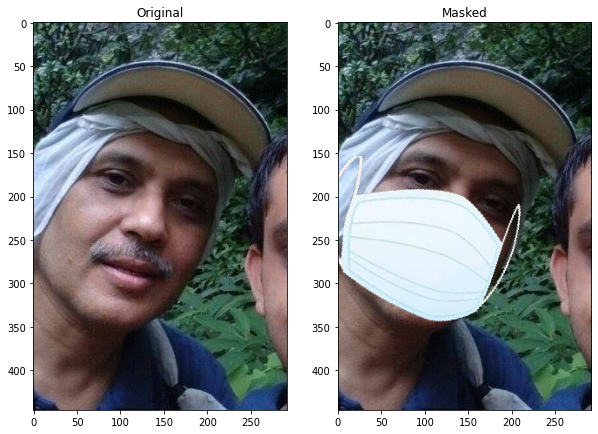

In [6]:
# Try on a single Image

FILE_PATH = "E:/Project_11_FaceMaskDetection/dataset/without mask/262.jpg"
MASK_IMAGE_PATH = "E:/Project_11_FaceMaskDetection/default_mask.png"

masked_face_image = Mask_Faces(FILE_PATH,MASK_IMAGE_PATH)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(Image.open(FILE_PATH))
plt.subplot(1,2,2)
plt.title("Masked")
plt.imshow(masked_face_image)
plt.show()

In [7]:
# Function to Mask Faces present in all Images within a directory

def Generate_Masked_Images (images_path,save_path,mask_image_path):

  print("Augmenting Images, Please Wait !")

  # Loop through all the Files
  for file_name in tqdm(os.listdir(images_path)):

    # Mask and Save in the Specified save_path
    try:

      masked_face_image = Mask_Faces(os.path.join(images_path,file_name),mask_image_path)
      masked_face_image.save(os.path.join(save_path,file_name.split('.')[0]+"_masked."+
                                          file_name.split('.')[-1]))
    except:
      continue

  print("Done !")

In [8]:
# Call the Function for a Directory

INPUT_DIR = "E:/Project_11_FaceMaskDetection/dataset/without mask"
SAVE_DIR = "E:/Project_11_FaceMaskDetection/Training_Data/augmented"
MASK_IMAGE_PATH = "E:/Project_11_FaceMaskDetection/default_mask.png"

Generate_Masked_Images (INPUT_DIR,SAVE_DIR,MASK_IMAGE_PATH)

Augmenting Images, Please Wait !


100%|████████████████████████████████████████████████████████████████████████████████| 686/686 [01:18<00:00,  8.71it/s]

Done !


# BLURRING EFFECTS

In [9]:
# Define Blurring Kernel Size Ranges, a Random Size would be chosen in the Specified Ranges
# Greater the Size, Higher is the Blurring Effect (Adjustments can be made according to the needs)

motion_blur_kernel_range = (6,10)  
average_blur_kernel_range = (3,9)
gaussian_blur_kernel_range = (3,10)

In [10]:
# Set Blurring Kernels to Use and their associated Probabilities

Blurring_Kernels = ["none","motion","gaussian","average"]
Probs = [0.1,0.4,0.25,0.25]

In [11]:
# Add Motion Blur to an Image in a Random Direction

def motion_blur(img):

  # Choose a Random Kernel Size
  kernel_size = np.random.randint(motion_blur_kernel_range[0],motion_blur_kernel_range[1])
  kernel = np.zeros((kernel_size, kernel_size))

  # Random Selection of Direction of Motion Blur
  types = ["vertical","horizontal","main_diagonal","anti_diagonal"]
  choice = np.random.choice(types)

  if choice=="vertical":
    kernel[:,int((kernel_size-1)/2)] = np.ones(kernel_size)/kernel_size
  
  elif choice=="horizontal":
    kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)/kernel_size
  
  elif choice=="main_diagonal":
    
    for i in range(kernel_size):
      kernel[i][i] = 1/kernel_size

  elif choice=="anti_diagonal":

    for i in range(kernel_size):
      kernel[i][kernel_size-i-1] = 1/kernel_size

  # Convolve and Return the Blurred Image
  return cv2.filter2D(img,-1,kernel)

In [12]:
# Add a Random Blur Effect to an Image with a Random Kernel Size (in the Specified Ranges)

def get_blurred_picture(img_path):
  
  # Randomly choose a Blurring Technique
  choice = np.random.choice(Blurring_Kernels,p=Probs)

  # Load Image
  img = cv2.imread(img_path)

  if choice=="none":

    random_blurred_img = img

  elif choice=="motion":
  
    random_blurred_img  = motion_blur(img)

  elif choice=="gaussian":

    kernel_size = np.random.randint(gaussian_blur_kernel_range[0],gaussian_blur_kernel_range[1])

    if kernel_size%2==0:
      kernel_size-=1
    
    random_blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

  elif choice=="average":
  
    kernel_size = np.random.randint(average_blur_kernel_range[0],average_blur_kernel_range[1])
    random_blurred_img = cv2.blur(img,(kernel_size,kernel_size))

  # Return Blurred Image  
  return random_blurred_img

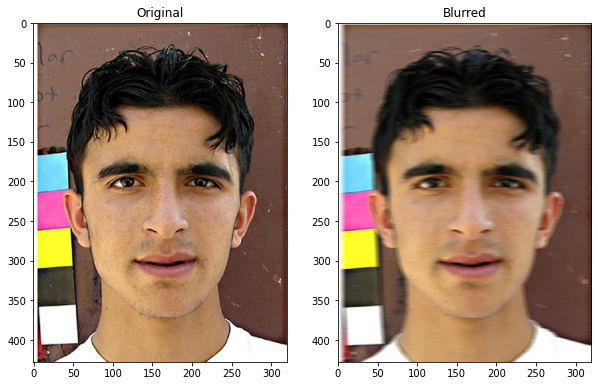

In [13]:
# Try on a single Image

FILE_PATH = "E:/Project_11_FaceMaskDetection/dataset/without mask/95.jpg"

blurred_image = get_blurred_picture(FILE_PATH)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(Image.open(FILE_PATH))
plt.subplot(1,2,2)
plt.title("Blurred")
plt.imshow(blurred_image[:,:,::-1])
plt.show()

In [14]:
# Function to Randomly Blur all Images within a directory

def Blur_Images (images_path,save_path):

  print("Blurring Images, Please Wait !")

  # Loop through all the Files
  for file_name in tqdm(os.listdir(images_path)):

    # Mask and Save in the Specified save_path
    try :

      blurred_image = get_blurred_picture(os.path.join(images_path,file_name))
      cv2.imwrite(os.path.join(save_path,file_name.split('.')[0]+"_blurred."+\
                                         file_name.split('.')[-1]),blurred_image)  
    except:
      continue

  print("Done !")

In [15]:
# Call the Function for a Directory

INPUT_DIR = "E:/Project_11_FaceMaskDetection/dataset/without mask"
SAVE_DIR = "E:/Project_11_FaceMaskDetection/Training_Data/augmented"

Blur_Images (INPUT_DIR,SAVE_DIR)

Blurring Images, Please Wait !


100%|███████████████████████████████████████████████████████████████████████████████| 686/686 [00:04<00:00, 164.50it/s]

Done !


✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅

## Face Mask Detector

In [18]:
# Install Required Libraries from PyPI

!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
#!pip install tqdm

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to c:\users\bristo vincent\appdata\local\temp\pip-req-build-tooa102y
  Resolved https://github.com/hukkelas/DSFD-Pytorch-Inference.git to commit 2bdd997d785e20ea39a911e9b3c451b7cdd3b152
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/hukkelas/DSFD-Pytorch-Inference.git 'C:\Users\Bristo Vincent\AppData\Local\Temp\pip-req-build-tooa102y'


In [21]:
# Import Required Libraries

import os
import numpy as np
import cv2
import face_detection
from tensorflow.keras.applications import resnet50
from keras.models import Model
from keras.layers import Dense,Dropout,AveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



In [20]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces

detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

BLURRING AUGMENTATION

In [22]:
# Define Blurring Kernel Size Ranges, a Random Size would be chosen in the Specified Ranges
# Greater the Size, Higher is the Blurring Effect (Adjustments can be made according to the needs)

motion_blur_kernel_range = (4,8)  
average_blur_kernel_range = (3,7)
gaussian_blur_kernel_range = (3,8)

In [23]:
# Set Blurring Kernels to Use and their associated Probabilities

Blurring_Kernels = ["none","motion","gaussian","average"]
Probs = [0.75,0.1,0.05,0.1]

In [24]:
# Add Motion Blur to an Image in a Random Direction

def motion_blur(img):

  # Choose a Random Kernel Size
  kernel_size = np.random.randint(motion_blur_kernel_range[0],motion_blur_kernel_range[1])
  kernel = np.zeros((kernel_size, kernel_size))

  # Random Selection of Direction of Motion Blur
  types = ["vertical","horizontal","main_diagonal","anti_diagonal"]
  choice = np.random.choice(types)

  if choice=="vertical":
    kernel[:,int((kernel_size-1)/2)] = np.ones(kernel_size)/kernel_size
  
  elif choice=="horizontal":
    kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)/kernel_size
  
  elif choice=="main_diagonal":
    
    for i in range(kernel_size):
      kernel[i][i] = 1/kernel_size

  elif choice=="anti_diagonal":

    for i in range(kernel_size):
      kernel[i][kernel_size-i-1] = 1/kernel_size

  # Convolve and Return the Blurred Image
  return cv2.filter2D(img,-1,kernel)

In [25]:
# Add a Random Blur Effect to an Image with a Random Kernel Size (in the Specified Ranges)

def get_blurred_picture(img):
  
  # Randomly choose a Blurring Technique
  choice = np.random.choice(Blurring_Kernels,p=Probs)

  # RGB to BGR for OpenCV
  img = img[:,:,::-1]

  if choice=="none":

    random_blurred_img = img

  elif choice=="motion":
  
    random_blurred_img  = motion_blur(img)

  elif choice=="gaussian":

    kernel_size = np.random.randint(gaussian_blur_kernel_range[0],gaussian_blur_kernel_range[1])

    if kernel_size%2==0:
      kernel_size-=1
    
    random_blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

  elif choice=="average":
  
    kernel_size = np.random.randint(average_blur_kernel_range[0],average_blur_kernel_range[1])
    random_blurred_img = cv2.blur(img,(kernel_size,kernel_size))

  # PreProcess for ResNet50
  preprocessed = resnet50.preprocess_input(random_blurred_img[:,:,::-1])
  
  return preprocessed

TRAINING

In [26]:
# Load Pretrained ResNet50 Model (without Last few Layers) 
# Freeze all the Layers

base_network  = resnet50.ResNet50(input_shape = (224,224,3),weights='imagenet',include_top=False)
for layer in base_network.layers:
  layer.trainaibale = False

In [27]:
# Define the Face Mask Classifier Model by adding a few Layers on top of the ResNet50 Pretrained Model

classifier_network = base_network.output
classifier_network = AveragePooling2D(pool_size=(7, 7),name = "Average_Pool_Final")(classifier_network)
classifier_network = Flatten(name = "Flatten_Final")(classifier_network)
classifier_network = Dense(128, activation="relu",name = "Dense_Final")(classifier_network)
classifier_network = Dropout(0.5,name = "Dropout_Final")(classifier_network)
classifier_network = Dense(1, activation="sigmoid", name = "Sigmoid_Classifier" )(classifier_network)

mask_classifier = Model(inputs=base_network.input, outputs=classifier_network)

In [28]:
# Set Path to the Dataset
# Faces would be extracted and placed in the specified Directory after Processing

Dataset_PATH = "E:/Project_11_FaceMaskDetection/dataset" 
Processed_Dataset_PATH = "E:/Project_11_FaceMaskDetection/Training_Data/Processed_Training_Data"


# Create Empty Directories 
#need to execute only once
os.mkdir(Processed_Dataset_PATH)
os.mkdir(os.path.join(Processed_Dataset_PATH,"with_mask"))
os.mkdir(os.path.join(Processed_Dataset_PATH,"without_mask"))

'os.mkdir(Processed_Dataset_PATH)\nos.mkdir(os.path.join(Processed_Dataset_PATH,"with_mask"))\nos.mkdir(os.path.join(Processed_Dataset_PATH,"without_mask"))'

In [ ]:
# Prepare the Data for Training 
# Extract Faces from the Dataset and Save them in the specified Directory

# There should be 2 Sub-Directories corresponding to Masked and Non-Masked Faces
paths = ["with_mask","without_mask"]

for path in paths:

  curr_path = os.path.join(Dataset_PATH,path)
  
  # Loop through all Images
  for file_name in tqdm.notebook.tqdm(os.listdir(curr_path)):

    try:
      
      image = cv2.imread(os.path.join(curr_path,file_name))

      # Detect Faces, Crop and Save
      detections = detector.detect(image[:,:,::-1])

      for j in range(len(detections)):
    
        face = image[int(detections[j][1]):int(detections[j][3]),
                     int(detections[j][0]):int(detections[j][2])]
        
        cv2.imwrite(os.path.join(Processed_Dataset_PATH,path)+"/"+file_name,face)
    
    except:
      continue 

In [29]:
Dataset_PATH = "/content/drive/MyDrive/FaceMaskandSocialDistancing/Training_Data"
Processed_Dataset_PATH = "E:/Project_11_FaceMaskDetection/Training_Data/Processed_Training_Data"

In [30]:
# Set the Hyper-Parameters

alpha = 0.00001
n_epochs = 5
mini_batch_size = 32

In [31]:
# Compile the Model

opt = Adam(learning_rate=alpha,decay = alpha/n_epochs)
mask_classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics = ['accuracy'])

In [32]:
# Define a ImageDataGenerator for Real-Time Data Augmentation
# Parameters can be Tuned for controlling the Augmentation

Data_Generator = ImageDataGenerator(horizontal_flip=True,
                                    brightness_range=[0.5,1.25],
                                    zoom_range=[0.8,1],
                                    rotation_range = 15,
                                    preprocessing_function=get_blurred_picture)

In [33]:
# Create a Data_Generator Instance

Train_Data_Generator = Data_Generator.flow_from_directory(Processed_Dataset_PATH,target_size=(224,224),
                                                          class_mode="binary",batch_size=mini_batch_size)

Found 1398 images belonging to 2 classes.


In [34]:
# Train the Model

mask_classifier.fit(x=Train_Data_Generator,
                    steps_per_epoch=(Train_Data_Generator.n//mini_batch_size),
                    epochs=n_epochs)

Epoch 1/5
43/43 [==============================] - 366s 8s/step - loss: 0.5360 - accuracy: 0.7299
Epoch 2/5
43/43 [==============================] - 355s 8s/step - loss: 0.1928 - accuracy: 0.9407
Epoch 3/5
43/43 [==============================] - 355s 8s/step - loss: 0.1098 - accuracy: 0.9663
Epoch 4/5
43/43 [==============================] - 356s 8s/step - loss: 0.0684 - accuracy: 0.9824
Epoch 5/5
43/43 [==============================] - 356s 8s/step - loss: 0.0596 - accuracy: 0.9802


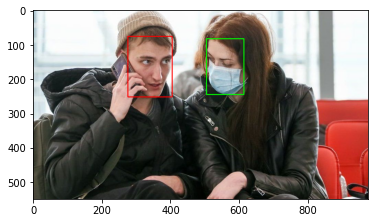

In [40]:
# Test the Model on a Picture

FILE_PATH = "E:/Project_11_FaceMaskDetection/test_2.jpg"

img = cv2.imread(FILE_PATH)
masked_faces = []
unmasked_faces = []

# Detect Faces
detections = detector.detect(img[:,:,::-1])

if detections.shape[0]>0:
      
  for i in range(detections.shape[0]):
  
    # Get Co-ordinates
    x1 = int(detections[i][0])
    x2 = int(detections[i][2])
    y1 = int(detections[i][1])
    y2 = int(detections[i][3])

    # Predict Output
    face_arr = cv2.resize(img[y1:y2,x1:x2,::-1], (224, 224), interpolation=cv2.INTER_NEAREST)
    face_arr = np.expand_dims(face_arr, axis=0)
    face_arr = resnet50.preprocess_input(face_arr)
    match = mask_classifier.predict(face_arr)

    if match[0][0]<0.5:
      masked_faces.append([x1,y1,x2,y2])
    else:
      unmasked_faces.append([x1,y1,x2,y2])

# Put Bounding Box on the Faces (Green:Masked,Red:Not-Masked)
for f in range(len(masked_faces)):

  a,b,c,d = masked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,255,0), 2)

for f in range(len(unmasked_faces)):

  a,b,c,d = unmasked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,0,255), 2)

# Show Results
#cv2.imshow('photo', img)
#cv2.waitKey(0)
plt.imshow(img[...,::-1])

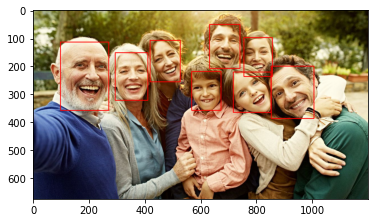

In [42]:
# Test the Model on a Picture

FILE_PATH = "E:/Project_11_FaceMaskDetection/test_1.jpg"

img = cv2.imread(FILE_PATH)
masked_faces = []
unmasked_faces = []

# Detect Faces
detections = detector.detect(img[:,:,::-1])

if detections.shape[0]>0:
      
  for i in range(detections.shape[0]):
  
    # Get Co-ordinates
    x1 = int(detections[i][0])
    x2 = int(detections[i][2])
    y1 = int(detections[i][1])
    y2 = int(detections[i][3])

    # Predict Output
    face_arr = cv2.resize(img[y1:y2,x1:x2,::-1], (224, 224), interpolation=cv2.INTER_NEAREST)
    face_arr = np.expand_dims(face_arr, axis=0)
    face_arr = resnet50.preprocess_input(face_arr)
    match = mask_classifier.predict(face_arr)

    if match[0][0]<0.5:
      masked_faces.append([x1,y1,x2,y2])
    else:
      unmasked_faces.append([x1,y1,x2,y2])

# Put Bounding Box on the Faces (Green:Masked,Red:Not-Masked)
for f in range(len(masked_faces)):

  a,b,c,d = masked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,255,0), 2)

for f in range(len(unmasked_faces)):

  a,b,c,d = unmasked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,0,255), 2)

# Show Results
#cv2.imshow('photo', img)
#cv2.waitKey(0)
plt.imshow(img[...,::-1])

In [ ]:
# Save the Trained Weights to Disk

SAVE_PATH = "drive/My Drive/Social_Distancing_with_AI/ResNet50_Classifier.h5" # give path where you need to save the model
mask_classifier.save(SAVE_PATH)

## Social Distancing Monitor

In [44]:
# Import Required Libraries

from sklearn.cluster import DBSCAN
from keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [52]:
# Path to the Working Environment


# On a Local Environment => set BASE_PATH  = ""
BASE_PATH = "E:/Project_11_FaceMaskDetection/"
# Path to Input Video File in the BASE_PATH
FILE_PATH = "video1.mp4"

In [53]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces

detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

# Other Availaible Detectors are RetinaNetResNet50 & RetinaNetMobileNetV1

In [54]:
# Load Pretrained Face Mask Classfier (Keras Model)

mask_classifier = load_model("E:/Project_11_FaceMaskDetection/ResNet50_Classifier_New.h5")

In [55]:
# Set the Safe Distance in Pixel Units (Minimum Distance Expected to be Maintained between People)
# This Parameter would Affect the Results, Adjust according to the Footage captured 

threshold_distance = 150

In [68]:
from tqdm import tqdm

In [72]:
##################################### Analyze the Video ################################################

# Load YOLOv3
net = cv2.dnn.readNet("E:/Project_11_FaceMaskDetection/yolov3.weights",
                      "E:/Project_11_FaceMaskDetection/yolov3.cfg")


# Load COCO Classes
classes = []
with open('E:/Project_11_FaceMaskDetection/coco.names', "r") as f:
    classes = [line.strip() for line in f.readlines()]
    

#newly added. executed last

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Fetch Video Properties
cap = cv2.VideoCapture(BASE_PATH + FILE_PATH )
fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# Create Directory for Storing Results (Make sure it doesn't already exists !)
os.mkdir(BASE_PATH+"ELResults")
os.mkdir(BASE_PATH+"ELResults/Extracted_Faces")
os.mkdir(BASE_PATH+"ELResults/Extracted_Persons")
os.mkdir(BASE_PATH+"ELResults/Frames")

# Initialize Output Video Stream
out_stream = cv2.VideoWriter(
    BASE_PATH+'ELResults/Output.mp4',
    cv2.VideoWriter_fourcc('X','V','I','D'),
    fps,
    (int(width),int(height)))

print("Processing Frames :")
for frame in tqdm(range(int(n_frames))):
    
    # Capture Frame-by-Frame
    ret, img = cap.read()

    # Check EOF
    if ret == False:
        break;

    # Get Frame Dimentions
    height, width, channels = img.shape

    # Detect Objects in the Frame with YOLOv3
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    
    # Store Detected Objects with Labels, Bounding_Boxes and their Confidences
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                
                # Get Center, Height and Width of the Box
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Topleft Co-ordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Initialize empty lists for storing Bounding Boxes of People and their Faces
    persons = []
    masked_faces = []
    unmasked_faces = []

    # Work on Detected Persons in the Frame
    for i in range(len(boxes)):
        if i in indexes:

            box = np.array(boxes[i])
            box = np.where(box<0,0,box)
            (x, y, w, h) = box

            label = str(classes[class_ids[i]])

            if label=='person':

                persons.append([x,y,w,h])
                
                # Save Image of Cropped Person (If not required, comment the command below)
                cv2.imwrite(BASE_PATH + "ELResults/Extracted_Persons/"+str(frame)
                            +"_"+str(len(persons))+".jpg",
                            img[y:y+h,x:x+w])

                # Detect Face in the Person
                person_rgb = img[y:y+h,x:x+w,::-1]   # Crop & BGR to RGB
                detections = detector.detect(person_rgb)

                # If a Face is Detected
                if detections.shape[0] > 0:

                  detection = np.array(detections[0])
                  detection = np.where(detection<0,0,detection)

                  # Calculating Co-ordinates of the Detected Face
                  x1 = x + int(detection[0])
                  x2 = x + int(detection[2])
                  y1 = y + int(detection[1])
                  y2 = y + int(detection[3])

                  try :

                    # Crop & BGR to RGB
                    face_rgb = img[y1:y2,x1:x2,::-1]   

                    # Preprocess the Image
                    face_arr = cv2.resize(face_rgb, (224, 224), interpolation=cv2.INTER_NEAREST)
                    face_arr = np.expand_dims(face_arr, axis=0)
                    face_arr = preprocess_input(face_arr)

                    # Predict if the Face is Masked or Not
                    score = mask_classifier.predict(face_arr)

                    # Determine and store Results
                    if score[0][0]<0.5:
                      masked_faces.append([x1,y1,x2,y2])
                    else:
                      unmasked_faces.append([x1,y1,x2,y2])

                    # Save Image of Cropped Face (If not required, comment the command below)
                    cv2.imwrite(BASE_PATH + "ELResults/Extracted_Faces/"+str(frame)
                                +"_"+str(len(persons))+".jpg",
                                img[y1:y2,x1:x2])

                  except:
                    continue
    
    # Calculate Coordinates of People Detected and find Clusters using DBSCAN
    person_coordinates = []

    for p in range(len(persons)):
      person_coordinates.append((persons[p][0]+int(persons[p][2]/2),persons[p][1]+int(persons[p][3]/2)))

    if len(persons)>0:
      clustering = DBSCAN(eps=threshold_distance,min_samples=2).fit(person_coordinates)
      isSafe = clustering.labels_
    else:
      isSafe = []

    # Count 
    person_count = len(persons)
    masked_face_count = len(masked_faces)
    unmasked_face_count = len(unmasked_faces)
    safe_count = np.sum((isSafe==-1)*1)
    unsafe_count = person_count - safe_count

    # Show Clusters using Red Lines
    arg_sorted = np.argsort(isSafe)

    for i in range(1,person_count):

      if isSafe[arg_sorted[i]]!=-1 and isSafe[arg_sorted[i]]==isSafe[arg_sorted[i-1]]:
        cv2.line(img,person_coordinates[arg_sorted[i]],person_coordinates[arg_sorted[i-1]],(0,0,255),2)

    # Put Bounding Boxes on People in the Frame
    for p in range(person_count):

      a,b,c,d = persons[p]

      # Green if Safe, Red if UnSafe
      if isSafe[p]==-1:
        cv2.rectangle(img, (a, b), (a + c, b + d), (0,255,0), 2)
      else:
        cv2.rectangle(img, (a, b), (a + c, b + d), (0,0,255), 2)

    # Put Bounding Boxes on Faces in the Frame
    # Green if Safe, Red if UnSafe
    for f in range(masked_face_count):

      a,b,c,d = masked_faces[f]
      cv2.rectangle(img, (a, b), (c,d), (0,255,0), 2)

    for f in range(unmasked_face_count):

      a,b,c,d = unmasked_faces[f]
      cv2.rectangle(img, (a, b), (c,d), (0,0,255), 2)

    # Show Monitoring Status in a Black Box at the Top
    cv2.rectangle(img,(0,0),(width,50),(0,0,0),-1)
    cv2.rectangle(img,(1,1),(width-1,50),(255,255,255),2)

    xpos = 15

    string = "Total People = "+str(person_count)
    cv2.putText(img,string,(xpos,35),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    xpos += cv2.getTextSize(string,cv2.FONT_HERSHEY_SIMPLEX,1,2)[0][0]

    string = " ( "+str(safe_count) + " Safe "
    cv2.putText(img,string,(xpos,35),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    xpos += cv2.getTextSize(string,cv2.FONT_HERSHEY_SIMPLEX,1,2)[0][0]

    string = str(unsafe_count)+ " Unsafe ) "
    cv2.putText(img,string,(xpos,35),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
    xpos += cv2.getTextSize(string,cv2.FONT_HERSHEY_SIMPLEX,1,2)[0][0]
    
    string = "( " +str(masked_face_count)+" Masked "+str(unmasked_face_count)+" Unmasked "+\
             str(person_count-masked_face_count-unmasked_face_count)+" Unknown )"
    cv2.putText(img,string,(xpos,35),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2)

    # Write Frame to the Output File
    out_stream.write(img)

    # Save the Frame in frame_no.png format (If not required, comment the command below)
    cv2.imwrite(BASE_PATH+"ELResults/Frames/"+str(frame)+".jpg",img)

    # Use if you want to see Results Frame by Frame
    # cv2.imshow('results',img)

    # Exit on Pressing Q Key
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release Streams
out_stream.release()
cap.release()
cv2.destroyAllWindows()

# Good to Go!
print("Done !")

Processing Frames :


  0%|                                                                                         | 0/1375 [00:00<?, ?it/s]D:\AnacondaInstallationFolder\anaconda3\envs\virenv\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  0%|                                                                               | 1/1375 [00:04<1:51:07,  4.85s/it]D:\AnacondaInstallationFolder\anaconda3\envs\virenv\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  0%|                                                                               | 2/1375 [00:09<1:45:28,  4.61s/it]D:\AnacondaInstallationFolder\anaconda3\envs\virenv\lib\site-packages\torch\autocas

Done !
